In [1]:
''' 
Analyze double-track sessions:

priorities:
----------
- rasters and tuning curves split by maps (compare to 2f)
- manifolds (fig. 3)
- running speed (4a, c, e)

other things:
------------
- stable/unstable (periodic firing) (compare to S2)
    - Inchon_0812, cells 745, 529, 717
- strong remappers in cue rich vs. poor blocks (compare to 2m)
    - is a strong remapper always a strong remapper?
    - plot avg dist to map in cue rich vs. poor blocks for each cell
    - requires good 2-factor fit in both tracks...
'''
import numpy as np
from dynamic_coding_analysis.analysis_pipeline import get_data
from dynamic_coding_analysis.analysis_pipeline import process_spikes as spk
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from tqdm import trange

C:\Users\ilow1\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# file paths
base = 'G:/My Drive/Giocomo Lab/RandomForage/'
data_folder = base + 'aggregate_data/'
save_folder = base + 'Dynamic MEC Coding Project/fig2_images_supp/double_track/'

In [3]:
''' run analysis on double-track sessions with >10 MEC neurons '''
mice = ['Seoul', 'Degu', 'Busan', 'Inchon', 'Ulsan']

mouse_IDs = ['4a', '4b', '4c', '5a', '5b']

sessions = [['0720cr', '0720cp', '0721cr', '0721cp'], # Seoul
            ['0720cr', '0720cp', '0721cr', '0721cp', '0722cr', '0722cp'], # Degu
            ['0730cr', '0730cp', '0801cr', '0801cp', '0802cr', '0802cp', '0803cr', '0803cp'], # Busan 
            ['0810cr', '0810cp', '0812cr', '0812cp', '0814cr', '0814cp'], # Inchon
            ['0802cr', '0802cp']] # Ulsan

In [4]:
'''
Assign colors based on track type
see: https://personal.sron.nl/~pault/#sec:qualitative Fig. 4
cue poor : green
cue rich : rose
'''
cp_color = [17/255, 119/255, 51/255, 1]
cr_color = [204/255, 102/255, 119/255, 1]

# cell_colors = sand, indigo, black/gray, teal
cell_colors = [[221/255, 204/255, 119/255, 1], 
               [51/255, 34/255, 136/255, 1], 'k', 
               [68/255, 170/255, 153/255, 1]]
all_map_colors = [[221/255, 204/255, 119/255, 1],
                  [51/255, 34/255, 136/255, 1],
                  [150/255, 150/255, 150/255, 1],
                  [68/255, 170/255, 153/255, 1]]

In [5]:
# make a dict to hold data
data = {}
for session, m in zip(sessions, mice):
    data[m] = {}
    for s in session:
        data[m][s] = {}

In [6]:
# load the data
from pathlib import Path

N_cells = 0
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        d['Y'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_FRtensor.npy')
        d['B'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_spikes.npy')
        d['A'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_behavior.npy')  
        
        # filter sessions with deleted AP/ML cells
        s_trunc = s[:4]
        cells = np.load(data_folder + 'gap_corrected/{}_{}_MEC_cellIDs.npy'.format(m, s_trunc))
        filt_file = data_folder + 'gap_corrected/{}_{}_MEC_idx.npy'.format(m, s_trunc)
        if Path(filt_file).exists():
            print(m + '_' + s + ' corrected for mistargeting')
            cell_idx = np.load(filt_file)
            cells = cells[cell_idx]
        d['cells'] = cells
        if 'cr' in s:
            N_cells += d['cells'].shape[0]
            print('{}_{} n cells = {}'.format(m, s, d['cells'].shape[0]))

Seoul_0720cr n cells = 69
Seoul_0721cr n cells = 47
Degu_0720cr n cells = 15
Degu_0721cr n cells = 55
Degu_0722cr n cells = 13
Busan_0730cr n cells = 27
Busan_0801cr corrected for mistargeting
Busan_0801cr n cells = 19
Busan_0801cp corrected for mistargeting
Busan_0802cr n cells = 34
Busan_0803cr n cells = 68
Inchon_0810cr n cells = 68
Inchon_0812cr n cells = 130
Inchon_0814cr n cells = 79
Ulsan_0802cr n cells = 214


In [7]:
N_mice = len(mice)
print('N = {} mice'.format(N_mice))
N_sessions = 0
for s in sessions:
    N_sessions += len(s)
print('N = {} blocks in {} sessions'.format(N_sessions, N_sessions//2))
print('N = {} cells'.format(N_cells))

N = 5 mice
N = 26 blocks in 13 sessions
N = 838 cells


In [8]:
# calculate similarity score across trials
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from dynamic_coding_analysis.analysis_pipeline import process_spikes as spk

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        sim_vec = np.abs(pdist(Y_unwrapped, 'correlation')-1)
        sim = squareform(sim_vec)
        d['similarity'] = sim

In [9]:
''' K-MEANS '''
from lvl.factor_models import KMeans as lvl_kmeans
from lvl.factor_models import NMF as lvl_soft_kmeans
from scipy.spatial.distance import cdist 
from scipy.special import logsumexp
def softmax(M):
    return np.exp(M - logsumexp(M, axis=-1, keepdims=True))

In [10]:
''' designate n maps '''
two_map = ['Degu_0720cp', 'Degu_0721cr', 
           'Busan_0803cr', 'Inchon_0810cr']
three_map = ['Seoul_0720cr', 'Seoul_0721cr', 'Degu_0721cp', 
             'Degu_0722cr', 'Degu_0722cp', 'Inchon_0812cr']

In [11]:
''' fit kmeans to get remaps '''
N_2map = 0
N_3map = 0
for m, session in zip(mice, sessions):
    for s in session:
        session_name = '{}_{}'.format(m, s)
        if session_name in two_map:
            N = 2
            model_kmeans = lvl_kmeans(n_components=N, n_restarts=500)
            N_2map += 1
        elif session_name in three_map:
            N = 3
            model_kmeans = lvl_kmeans(n_components=N, n_restarts=500)
            N_3map += 1
        else:
            continue
        
        d = data[m][s]
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        
        # fit model and get params
        model_kmeans.fit(Y_unwrapped)
        W, H = model_kmeans.factors
        Y_hat = model_kmeans.predict()
        d['kmeans'] = {}
        d['kmeans']['W'] = W
        d['kmeans']['H'] = H
        d['kmeans']['Y_hat'] = Y_hat  

In [12]:
print('N 2 map sessions = {}'.format(N_2map))
print('N 3 map sessions = {}'.format(N_3map))

N 2 map sessions = 4
N 3 map sessions = 6


In [13]:
# reassign map 0 to be the slower map
for m, session in zip(mice, sessions):
    for s in session:
        session_name = '{}_{}'.format(m, s)
        if session_name in two_map:
            d = data[m][s]
            A = d['A']
            W = d['kmeans']['W']
            H = d['kmeans']['H']

            # get map indices
            map_idx = W[:, 0].astype(bool)
            trials = A[:, 2]
            map0_idx = np.zeros_like(trials)
            map1_idx = np.zeros_like(trials)
            for i, t in enumerate(np.unique(trials)):
                if map_idx[i]:
                    map0_idx[trials == t] = 1
                else:
                    map1_idx[trials == t] = 1
            map0_idx = map0_idx.astype(bool)
            map1_idx = map1_idx.astype(bool)

            # get running speed in each map and assign map 0 to slower map
            speed = A[:, 1]
            speed_0 = np.nanmean(speed[map0_idx])
            speed_1 = np.nanmean(speed[map1_idx])

            if speed_1 < speed_0: # swap labels
                d['map0_idx'] = 1
            else:
                d['map0_idx'] = 0

In [14]:
''' get distance to cluster on each trial '''
for m, session in zip(mice, sessions):
    for s in session:
        session_name = '{}_{}'.format(m, s)
        if session_name in two_map:
            d = data[m][s]
            Y = d['Y'].copy()
            Y = Y.transpose(0, 2, 1)
            Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
            n_trials, n_cells, n_pos = Y.shape

            # get kmeans fit
            H = d['kmeans']['H']
            N = H.shape[0]
            map0_idx = d['map0_idx']

            # get centroids
            c1 = H[map0_idx]
            c2 = H[map0_idx-1]

            # project down to connecting line
            proj = (c1 - c2) / np.linalg.norm(c1 - c2)
            projc1 = c1 @ proj
            projc2 = c2 @ proj
            projY = Y_unwrapped @ proj

            # get distance
            dd = (projY - projc2) / (projc1 - projc2)
            d['dist'] = 2 * (dd - .5) # classify -1 or 1
    #         d['dist'] = 1 / (1 + np.exp(-dd)) # convert to probability -- trying without this

In [15]:
all_remappers = two_map.copy()
all_remappers = all_remappers + three_map

In [16]:
''' save remap index: '''
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        session_name = '{}_{}'.format(m, s)
        if session_name in all_remappers:
            d = data[m][s]
            W = d['kmeans']['W']
            trials = np.arange(0, W.shape[0]-1)

            # define remaps
            remap_idx = np.asarray([])
            for w in range(W.shape[1]):
                remaps = np.where(np.abs(np.diff(W[:, w])))[0]
                remap_idx = np.append(remap_idx, remaps)
            remap_idx = np.unique(remap_idx)
            d['remap_idx'] = remap_idx.astype(int)

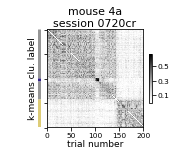

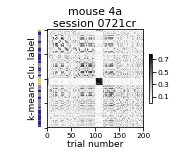

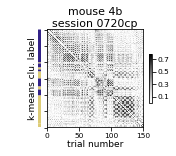

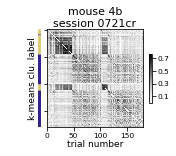

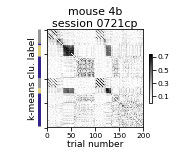

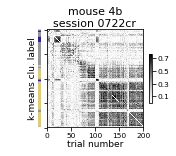

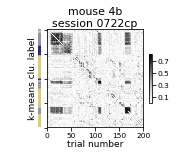

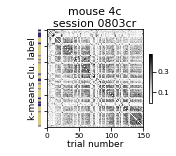

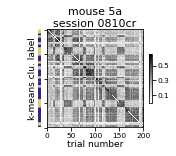

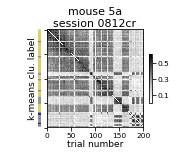

In [17]:
''' save k-means fit + similarity '''
CLU_W = 3
for i, m in enumerate(mice):
    session = sessions[i]
    m_ID = mouse_IDs[i]
    for s in session:
        session_name = '{}_{}'.format(m, s)
        if session_name in all_remappers:
            d = data[m][s]
            A = d['A']
            gs = gridspec.GridSpec(1, 10, hspace=1.5)
            f = plt.figure(figsize=(2.4, 1.8))

            # set axes
            ax1 = plt.subplot(gs[1:])

            # plot Euclidean similarity score
            sim = d['similarity']
            im = ax1.imshow(sim, aspect='auto', cmap='Greys')
            ax1.tick_params(labelleft=False)
            ax1.set_ylabel('k-means clu. label', fontsize=9, labelpad=10)
            ax1.set_xlabel('trial number', fontsize=9, labelpad=1)
            ax1.set_title('mouse ' + m_ID + '\nsession ' + s, fontsize=11, pad=3)
            ax1.tick_params(which='major', labelsize=7.5, pad=2)
            
            #colorbar
            cbar = f.colorbar(im, shrink=0.5,
                              ticks=np.arange(0.1, 0.8, 0.2))
            cbar.ax.tick_params(labelsize=7.5, pad=2)

            # k-means cluster labels
            ax2 = plt.subplot(gs[0])
            remap_idx = d['remap_idx']
            W = d['kmeans']['W'].copy()
            start_idx = np.append([0], remap_idx)
            end_idx = np.append(remap_idx, W.shape[0])
            map_colors = []
            for i in np.where(W[remap_idx, :])[1]:
                map_colors.append(all_map_colors[i])
            map_colors.append(all_map_colors[np.where(W[-1, :])[0][0]])
            ax2.vlines(np.full(start_idx.shape[0], 1), start_idx, end_idx, 
                       colors=map_colors, lw=np.full(start_idx.shape[0], CLU_W), 
                       linestyles=np.full(start_idx.shape[0], 'solid'))
            ax2.set_xlim([0.5, 1.5])
            ax2.set_ylim([W.shape[0], 0])
            plt.axis('off')    

            f.savefig(save_folder + m + '_' + s + '_similarity.png', dpi=400, bbox_inches='tight')
            plt.show()

In [19]:
''' get map indices '''
for m, session in zip(mice, sessions):
    for s in session:
        session_name = '{}_{}'.format(m, s)
        if session_name in all_remappers:
            d = data[m][s]
            A = d['A'].copy()

            # get map indices
            W = d['kmeans']['W']
            trials = A[:, 2]

            map_idx = np.zeros([4, trials.shape[0]])
            for i, t in enumerate(np.unique(trials)):
                for j in range(W.shape[1]):
                    if W[i, j]:
                        map_idx[j, trials == t] = 1

            d['idx'] = map_idx.astype(bool)

In [32]:
''' single cell examples '''
m = 'Inchon'
s = '0812cr'
cell_IDs = [508, 522, 745]

d = data[m][s]
cells = d['cells']

print('n cells = ' + str(cells.shape[0]))

n cells = 130


In [33]:
# get FR in each map
A = d['A']
B = d['B']
dt = 0.02

# get map indices
W = d['kmeans']['W']
map0_idx = d['idx'][0, :].copy()
map1_idx = d['idx'][1, :].copy()

# get FR by position in each map + naive for all cells   
FR, binned_pos, FR_sem = spk.tuning_curve(A[:, 0], B, dt, b=2, SEM=True)
FR_0, binned_pos, FR_0_sem = spk.tuning_curve(A[map0_idx, 0], B[map0_idx, :], dt, b=2, SEM=True)
FR_1, binned_pos, FR_1_sem = spk.tuning_curve(A[map1_idx, 0], B[map1_idx, :], dt, b=2, SEM=True)

if '{}_{}'.format(m, s) in three_map:
    map2_idx = d['idx'][2, :].copy()
    FR_2, binned_pos, FR_2_sem = spk.tuning_curve(A[map2_idx, 0], B[map2_idx, :], dt, b=2, SEM=True)

In [34]:
all_FR = np.zeros([FR_0.shape[0], FR_0.shape[1], W.shape[1]])
all_FR_sem = np.zeros([FR_0.shape[0], FR_0.shape[1], W.shape[1]])

all_FR[:, :, 0] = FR_0
all_FR_sem[:, :, 0] = FR_0_sem
all_FR[:, :, 1] = FR_1
all_FR_sem[:, :, 1] = FR_1_sem
if '{}_{}'.format(m, s) in three_map:
    all_FR[:, :, 2] = FR_2
    all_FR_sem[:, :, 2] = FR_2_sem

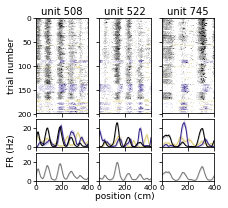

In [35]:
''' fig. 2g '''
gs = gridspec.GridSpec(5, 3, hspace=0.2)
f = plt.figure(figsize=(3.2, 3)) 
PT_SIZE = 1
LW_MEAN = 1
LW_SEM = 0.3

for i, cell_ID in enumerate(cell_IDs):
    # set axes
    ax0 = plt.subplot(gs[:3, i])
    ax1 = plt.subplot(gs[3:4, i])
    ax2 = plt.subplot(gs[4:, i])
    
    # cycle through maps
    for j in range(W.shape[1]):
        # draw raster
        map_idx = d['idx'][j, :].copy()
        sdx = B[map_idx, np.where(cells==cell_ID)[0][0]].astype(bool)
        if m == 'Busan':
            ax0.scatter(A[map_idx, 0][sdx], A[map_idx, 2][sdx], color=cell_colors[j], lw=0, s=PT_SIZE*3, alpha=.1)
        else:
            ax0.scatter(A[map_idx, 0][sdx], A[map_idx, 2][sdx], color=cell_colors[j], lw=0, s=PT_SIZE, alpha=.1)
        
        # plot tuning curves with SEM
        sdx = (np.where(cells==cell_ID)[0][0]).astype(int)
        FR_map = np.squeeze(all_FR[:, :, j])
        sem_map = np.squeeze(all_FR_sem[:, :, j])
        ax1.plot(FR_map[:, sdx], color=cell_colors[j], lw=LW_MEAN, alpha=1)
        ax1.fill_between(binned_pos/2, FR_map[:, sdx] + sem_map[:, sdx], FR_map[:, sdx] - sem_map[:, sdx],
                         color=cell_colors[j], linewidth=LW_SEM, alpha=0.2)
    
    # plot naive tuning curve with SEM
    sdx = (np.where(cells==cell_ID)[0][0]).astype(int)
    ax2.plot(FR[:, sdx], 'k', lw=LW_MEAN, alpha=0.5)
    ax2.fill_between(binned_pos/2, FR[:, sdx] + FR_sem[:, sdx], FR[:, sdx] - FR_sem[:, sdx],
                     color='k', linewidth=LW_SEM, alpha=0.1)

    # format axes
    ax0.set_xlim((0, 400))
    ax0.set_xticks(np.arange(0, 425, 200))
    ax0.tick_params(labelbottom=False, axis='both', which='major', labelsize=7.5, pad=0.5)
    ylim_ax = [0, np.max(A[:, 2])]
    ax0.set_ylim(ylim_ax[::-1])
    ax0.set_title('unit {}'.format(cell_ID), fontsize=10, pad=3)
     
    if i == 0:
        ax0.set_ylabel('trial number', fontsize=9, labelpad=1)
        ax2.set_ylabel('FR (Hz)', horizontalalignment='left', fontsize=9, labelpad=6)
    else:
        ax0.tick_params(labelleft=False)
        ax1.tick_params(labelleft=False)
        ax2.tick_params(labelleft=False)
        
    ax1.set_xlim([0, 200])
    ax1.set_xticks(np.arange(0, 225, 100))
    ax1.tick_params(labelbottom=False, axis='both', which='major', labelsize=7.5, pad=0.5)
    ax2.tick_params(axis='both', which='major', labelsize=7.5, pad=0.5)
    ax2.set_xlim([0, 200])
    ax2.set_xticks(np.arange(0, 225, 100))
    ax2.set_xticklabels(np.arange(0, 450, 200))
    if i == 1:
        ax2.set_xlabel('position (cm)', fontsize=9, labelpad=1)
    
    # Inchon
    ax1.set_ylim([0, 30])
    ax1.set_yticks([0, 20])
    ax2.set_ylim([0, 30])
    ax2.set_yticks([0, 20])
    
f.savefig(save_folder + m + '_' + s + '_example_rasters.png', dpi=400, bbox_inches='tight')
plt.show()

In [36]:
''' save remap vs. stable index:
- limit "stable periods" to n_trials > 5
- stable trials = all trials except 4 trials surrounding remap point
- remap trials = trials on each side of remap point
'''
near_N = 2
trial_min = 2*near_N + 1
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        if '{}_{}'.format(m, s) in all_remappers:
            d = data[m][s]
            W = d['kmeans']['W']
            trials = np.arange(0, W.shape[0]-1)

            # define remaps
            remap_idx = np.asarray([])
            for w in range(W.shape[1]):
                remaps = np.where(np.abs(np.diff(W[:, w])))[0]
                remap_idx = np.append(remap_idx, remaps)

            # define stable
            for i in range(near_N):
                if i == 0:
                    near_remaps = np.append(remap_idx, remap_idx+(i+1))
                elif i < near_N:
                    near_remaps = np.append(np.append(near_remaps, remap_idx-i), remap_idx+(i+1))
            near_remaps = np.sort(near_remaps)
            stable_idx = np.setdiff1d(trials, near_remaps)

            # keep only remaps at least 5 trials from last remap (stable trials should by definition fit this bill)
            boundary_trials = np.insert(remap_idx, 0, 0)
            remap_idx = np.setdiff1d(remap_idx, remap_idx[np.diff(boundary_trials) < trial_min])
            remap_idx = np.sort(np.append(remap_idx, remap_idx+1))

            # save the data
            d['remap_idx'] = [stable_idx.astype(int), remap_idx.astype(int)]

In [37]:
''' get avg running speed on each trial '''
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        if '{}_{}'.format(m, s) in all_remappers:
            d = data[m][s]

            # speed
            A = d['A']
            speed = A[:, 1]
            obs_trials = A[:, 2]
            avg_speed = np.zeros_like(np.unique(obs_trials))
            for t in np.unique(obs_trials).astype(int):
                avg_speed[t] = np.mean(speed[obs_trials==t])
            d['avg_speeds'] = avg_speed

In [38]:
MIN_REMAPS = 3

# store mean speeds for each session and all speed values
mean_speed_remap = []
mean_speed_stable = []
sem_remaps = []
sem_stable = []   

ct = -1
for m, session in zip(mice, sessions):
    ct += 1
    mean_speed_remap.append(np.zeros(len(session)))
    mean_speed_stable.append(np.zeros(len(session)))
    sem_remaps.append(np.zeros(len(session)))
    sem_stable.append(np.zeros(len(session)))   
    
    for i, s in enumerate(session):
        if '{}_{}'.format(m, s) in all_remappers:
            d = data[m][s]
            stable_idx = d['remap_idx'][0]
            remap_idx = d['remap_idx'][1]

            # keep only sessions with at least MIN_REMAPS
            if remap_idx[::2].shape[0] < MIN_REMAPS:
                print(m + '_' + s + ' fewer than ' + str(MIN_REMAPS) + ' remaps')
                continue

            # get average speed on remap vs. stable trials
            avg_speed_remaps = d['avg_speeds'][remap_idx]
            avg_speed_stable = d['avg_speeds'][stable_idx]

            # store mean speed and SEM
            mean_speed_remap[-1][i] = np.mean(avg_speed_remaps)
            sem_remaps[-1][i] = stats.sem(avg_speed_remaps)
            mean_speed_stable[-1][i] = np.mean(avg_speed_stable)
            sem_stable[-1][i] = stats.sem(avg_speed_stable)

Seoul_0720cr fewer than 3 remaps


In [39]:
''' get difference in running speeds for each remap/stable block pair '''
diff_speed = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        if '{}_{}'.format(m, s) in all_remappers:
            d = data[m][s]
            avg_speeds = d['avg_speeds']

            # get indices
            stable_idx = d['remap_idx'][0]
            remap_idx = d['remap_idx'][1]
            if remap_idx.shape[0] < MIN_REMAPS:
                continue
            remap_speeds_both = avg_speeds[remap_idx]
            remap_speeds = (remap_speeds_both[::2] + remap_speeds_both[1::2])/2

            # get avg stable speed by block
            bdx = np.digitize(stable_idx, remap_idx[::2])
            stable_blocks = np.zeros(remap_idx[::2].shape[0])
            for b in np.unique(bdx):
                if b < stable_blocks.shape[0]:
                    stable_blocks[b] = np.mean(avg_speeds[stable_idx[bdx==b]])

            # calculate percent difference remap vs. stable
            diff_session = ((stable_blocks - remap_speeds) / stable_blocks)*100
            diff_speed = np.append(diff_speed, diff_session)

In [40]:
print('mean, sem')
print('stable speed - remap speed: {}, {}'.format(np.round(np.mean(diff_speed), 2), np.round(stats.sem(diff_speed), 2)))
print('n pairs = {}'.format(diff_speed.shape[0]))
stat, p_diff = stats.wilcoxon(diff_speed)
print('\np = ' + str(p_diff))

mean, sem
stable speed - remap speed: 7.01, 2.07
n pairs = 86

p = 0.00027187624161349874


In [41]:
''' example session '''
m = 'Inchon'
s = '0812cr'

d = data[m][s]

In [42]:
# get data
W = d['kmeans']['W']
A = d['A']
speed = A[:, 1]
obs_trials = A[:, 2]
avg_speed = d['avg_speeds']

In [43]:
# get avg speed for each stable block
stable_idx = d['remap_idx'][0]
remap_idx = d['remap_idx'][1]
remap_speeds_both = avg_speed[remap_idx]
remap_speeds = (remap_speeds_both[::2] + remap_speeds_both[1::2])/2

# get avg stable speed by block
bdx = np.digitize(stable_idx, remap_idx[::2])
stable_blocks = np.zeros(remap_idx[::2].shape[0])
for b in np.unique(bdx):
    if b < stable_blocks.shape[0]:
        stable_blocks[b] = np.mean(avg_speed[stable_idx[bdx==b]])

In [44]:
remap_mice = []
remap_sessions = []
for m, session in zip(mice, sessions):
    remap_session = []
    for s in session:
        if '{}_{}'.format(m, s) in all_remappers:
            if m in remap_mice:
                remap_session.append(s)
            else:
                remap_session.append(s)
                remap_mice.append(m)
    if m in remap_mice:                
        remap_sessions.append(remap_session)

In [45]:
print(remap_mice)
print(remap_sessions)

['Seoul', 'Degu', 'Busan', 'Inchon']
[['0720cr', '0721cr'], ['0720cp', '0721cr', '0721cp', '0722cr', '0722cp'], ['0803cr'], ['0810cr', '0812cr']]


[ 0.          0.         46.01865864  0.        ]
[ 0.          0.         46.50075816  0.        ]
[ 0.         36.46557958 41.42499091 41.46885898 52.78049161 51.20295404]
[ 0.         35.25110903 36.99526703 40.58177737 48.3050118  50.93165342]
[ 0.          0.          0.          0.          0.          0.
 38.85632559  0.        ]
[ 0.          0.          0.          0.          0.          0.
 29.71687147  0.        ]
[31.73167959  0.         35.11773153  0.          0.          0.        ]
[27.53905327  0.         30.99226619  0.          0.          0.        ]


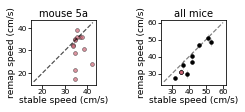

In [51]:
''' plot remap vs. stable speed example mouse and all mice '''
gs = gridspec.GridSpec(1, 2, wspace=1)
f = plt.figure(figsize=(3.5, 1.2))
PT_SIZE = 15
PT_LW = 0.5
UNITY_WIDTH = 1.2
SEM_WIDTH = 1

N_mice_restricted = 0
N_sess_restricted = 0

i = -1
ax0 = plt.subplot(gs[1])
for m, session in zip(remap_mice, remap_sessions):
    i += 1
    
    # get data
    avg_stable = mean_speed_stable[i]
    avg_remap = mean_speed_remap[i]
    sem_s = sem_stable[i]
    sem_r = sem_remaps[i]
    idx = avg_stable > 0
    
    print(avg_stable)
    print(avg_remap)
    
    if any(idx):
        N_mice_restricted += 1
        N_sess_restricted += np.sum(idx)
    
    # plot it
    ax0.vlines(avg_stable[idx], avg_remap[idx] - sem_r[idx], avg_remap[idx] + sem_r[idx], 
              colors='k', lw=SEM_WIDTH, linestyles='solid', alpha=0.2, zorder=1)
    ax0.hlines(avg_remap[idx], avg_stable[idx] - sem_s[idx], avg_stable[idx] + sem_s[idx], 
              colors='k', lw=SEM_WIDTH, linestyles='solid', alpha=0.2, zorder=1)
    ax0.scatter(avg_stable[idx], avg_remap[idx], s=PT_SIZE, color='k', lw=PT_LW, zorder=2)

# plot unity
ax0.set_xticks(np.arange(30, 65, 10))
ax0.set_yticks(np.arange(30, 65, 10))
xlims = ax0.get_xlim()
ylims = ax0.get_ylim()
min_speed = np.min([xlims[0], ylims[0]])
max_speed = np.max([xlims[1], ylims[1]])
plt.plot([min_speed, max_speed], [min_speed, max_speed], '--k', lw=UNITY_WIDTH, alpha=0.5)

ax0.set_title('all mice', fontsize=10, pad=3)
ax0.set_xlabel('stable speed (cm/s)', fontsize=9, labelpad=1)
ax0.tick_params(axis='both', which='major', labelsize=7.5, pad=0.5)
ax0.set_ylabel('remap speed (cm/s)', fontsize=9, labelpad=1)

# stable vs. remaps
m = 'Inchon'
s = '0812cr'
d = data[m][s]

# highlight on the summary plot
stable_idx = d['remap_idx'][0]
remap_idx = d['remap_idx'][1]
avg_speeds = d['avg_speeds']
ax0.scatter(np.mean(avg_speeds[stable_idx]), np.mean(avg_speeds[remap_idx]), 
            s=PT_SIZE, lw=PT_LW, 
            facecolors=cr_color, edgecolors='k', zorder=3)

# plot each pair
ax2 = plt.subplot(gs[0])
ax2.scatter(stable_blocks, remap_speeds, 
            facecolors=cr_color, edgecolors='k', 
            s=PT_SIZE, lw=PT_LW, alpha=0.7)
xlims = ax2.get_xlim()
ylims = ax2.get_ylim()
ax2.set_xticks(np.arange(20, 45, 10))
ax2.set_yticks(np.arange(20, 45, 10))
min_speed = np.min([xlims[0], ylims[0]])
max_speed = np.max([xlims[1], ylims[1]])
ax2.plot([min_speed, max_speed], [min_speed, max_speed], '--k', lw=UNITY_WIDTH, alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=7.5, pad=0.5)
ax2.set_xlabel('stable speed (cm/s)', fontsize=9, labelpad=1)
ax2.set_ylabel('remap speed (cm/s)', fontsize=9, labelpad=1)
ax2.set_title('mouse {}'.format(mouse_IDs[mice.index(m)]), fontsize=10, pad=3)

f.savefig(save_folder + 'stableVSremap.png', dpi=400, bbox_inches='tight')
plt.show()

In [52]:
print('n mice >' + str(MIN_REMAPS) + ' remaps = ' + str(N_mice_restricted))
print('n sessions >' + str(MIN_REMAPS) + ' remaps = ' + str(N_sess_restricted))

n mice >3 remaps = 4
n sessions >3 remaps = 9


In [53]:
m = 'Inchon'
s = '0812cr'
d = data[m][s]
W = d['kmeans']['W']

In [54]:
''' save remap index: '''
# define remaps unfiltered
remap_idx_unfilt = np.asarray([])
for w in range(W.shape[1]):
    remaps = np.where(np.abs(np.diff(W[:, w])))[0]
    remap_idx_unfilt = np.append(remap_idx_unfilt, remaps)
remap_idx_unfilt = np.unique(remap_idx_unfilt)
remap_idx_unfilt = remap_idx_unfilt.astype(int)

# get map colors
start_idx = np.append([0], remap_idx_unfilt)
end_idx = np.append(remap_idx_unfilt, W.shape[0])
map_colors = []
for i in np.where(W[remap_idx_unfilt, :])[1]:
    map_colors.append(all_map_colors[i])
map_colors.append(all_map_colors[np.where(W[-1, :])[0][0]])

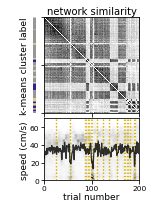

In [56]:
''' plot similarity w/ clusters beside, speed below '''
gs = gridspec.GridSpec(5, 10, hspace=0.2)
f = plt.figure(figsize=(1.9, 3))
DIST_W = 1
SPEED_W = 1.25
REMAP_W = 1.25
CLU_W = 3

# similarity
ax0 = plt.subplot(gs[:3, 1:])
sim = d['similarity']
im = ax0.imshow(sim, clim=[0, 0.6], aspect='auto', cmap='Greys')
ax0.tick_params(labelbottom=False, labelleft=False)
ax0.tick_params(axis='both', which='major', labelsize=7.5, pad=0.5)
ax0.set_ylabel('cluster label', labelpad=24)
ax0.set_title('network similarity', fontsize=10, pad=3)
ax0.set_xticks(np.arange(0, 202, 100))
ax0.set_yticks(np.arange(0, 202, 100))
xlim_ax0 = ax0.get_xlim()
        
# speed by trial
ax1 = plt.subplot(gs[3:, 1:])
ax1.hexbin(obs_trials, speed, gridsize=40, cmap='Greys')
ax1.plot(avg_speed, '-k', linewidth=SPEED_W, alpha=0.8)
ax1.set_ylabel('speed (cm/s)', fontsize=9, labelpad=1)
ax1.set_xlim(xlim_ax0)
ax1.set_xlabel('trial number', fontsize=9, labelpad=1)
# ax1.set_yticks(np.arange(20, 45, 10))
ax1.set_xticks(np.arange(0, 202, 100))
ax1.tick_params(axis='both', which='major', labelsize=7.5, pad=1)

# remaps
ylim_ax1 = ax1.get_ylim()
ax1.vlines(remap_idx, 0, ylim_ax1[1], colors=np.full(remap_idx.shape[0], 'xkcd:gold'), 
           lw=np.full(start_idx.shape[0], REMAP_W), linestyles=np.full(start_idx.shape[0], 'dotted'))
ax1.set_ylim([0, ylim_ax1[1]])
    
# k-means cluster labels
ax2 = plt.subplot(gs[:3, 0])
W = d['kmeans']['W'].copy()
start_idx = np.append([0], remap_idx_unfilt)
end_idx = np.append(remap_idx_unfilt, W.shape[0])
ax2.vlines(np.full(start_idx.shape[0], 1), start_idx, end_idx, 
           colors=map_colors, lw=np.full(start_idx.shape[0], CLU_W), linestyles=np.full(start_idx.shape[0], 'solid'))
ax2.set_xlim([0.5, 5])
ax2.set_ylim([W.shape[0], 0])
plt.axis('off')    
ax0.set_ylabel('k-means cluster label', fontsize=9, labelpad=15)
    
f.savefig(save_folder + m + '_' + s + '_sim_speed.png', dpi=400, bbox_inches='tight')
plt.show()

In [57]:
''' example similarity matrices (together and split) '''
# m = 'Inchon'
# s = '0810'
m = 'Degu'
s = '0721'
s_cr = s + 'cr'
s_cp = s + 'cp'
session = [s, s_cr, s_cp]

In [58]:
# get data for combined session
data[m][s] = {}
d = data[m][s]
d['Y'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_FRtensor.npy')

In [59]:
# get similarity for combined session
Y = d['Y'].copy()
Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
sim_vec = np.abs(pdist(Y_unwrapped, 'correlation')-1)
sim = squareform(sim_vec)
d['similarity'] = sim

In [60]:
titles = ['full session', 'cue rich', 'cue poor']

In [61]:
''' save remap index: '''
for s in session[1:]:
    # define remaps unfiltered
    remap_idx_unfilt = np.asarray([])
    for w in range(W.shape[1]):
        remaps = np.where(np.abs(np.diff(W[:, w])))[0]
        remap_idx_unfilt = np.append(remap_idx_unfilt, remaps)
    remap_idx_unfilt = np.unique(remap_idx_unfilt)
    remap_idx_unfilt = remap_idx_unfilt.astype(int)

    # get map colors
    start_idx = np.append([0], remap_idx_unfilt)
    end_idx = np.append(remap_idx_unfilt, W.shape[0])
    map_colors = []
    for i in np.where(W[remap_idx_unfilt, :])[1]:
        map_colors.append(all_map_colors[i])
    map_colors.append(all_map_colors[np.where(W[-1, :])[0][0]])
    
    d['map_colors'] = map_colors

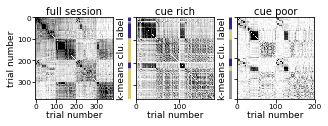

In [72]:
# plot similarity combined and split
gs = gridspec.GridSpec(1, 31, wspace=1)
f = plt.figure(figsize=(5, 1.5))
for i, s in enumerate(session):
    d = data[m][s]
    sim = d['similarity']
    
    # set axes
    if i==0:
        ax0 = plt.subplot(gs[:9])
    elif i==1:
        ax2 = plt.subplot(gs[10]) # kmeans clusters
        ax0 = plt.subplot(gs[11:20]) # similarity
    else:
        ax2 = plt.subplot(gs[21]) # kmeans clusters
        ax0 = plt.subplot(gs[22:]) # similarity
    
    # plot similarity
    im = ax0.imshow(sim, clim=[0, 0.6], aspect='auto', cmap='Greys', interpolation='none')
    ax0.tick_params(axis='both', which='major', labelsize=7.5, pad=0.5)
    ax0.set_title(titles[i], fontsize=10, pad=3)
    ax0.set_xlabel('trial number', fontsize=9, labelpad=1)

    if i==0:
        ax0.set_ylabel('trial number', fontsize=9, labelpad=1)

        ax0.set_xticks(np.arange(0, 305, 100))
        ax0.set_yticks(np.arange(0, 305, 100))
    else:
        ax0.tick_params(labelleft=False)
        ax0.set_ylabel('k-means clu. label', fontsize=9, labelpad=10)
#         ax0.set_xticks(np.arange(0, 205, 100))
#         ax0.set_yticks(np.arange(0, 205, 100))

    #plot k-means cluster labels
    if i!=0:
        # define remaps unfiltered
        W = d['kmeans']['W'].copy()
        remap_idx_unfilt = np.asarray([])
        for w in range(W.shape[1]):
            remaps = np.where(np.abs(np.diff(W[:, w])))[0]
            remap_idx_unfilt = np.append(remap_idx_unfilt, remaps)
        remap_idx_unfilt = np.unique(remap_idx_unfilt)
        remap_idx_unfilt = remap_idx_unfilt.astype(int)

        # get map colors
        start_idx = np.append([0], remap_idx_unfilt)
        end_idx = np.append(remap_idx_unfilt, W.shape[0])
        map_colors = []
        for i in np.where(W[remap_idx_unfilt, :])[1]:
            map_colors.append(all_map_colors[i])
        map_colors.append(all_map_colors[np.where(W[-1, :])[0][0]])
        
        ax2.vlines(np.full(start_idx.shape[0], 1), start_idx, end_idx, 
                   colors=map_colors, lw=np.full(start_idx.shape[0], CLU_W), 
                   linestyles=np.full(start_idx.shape[0], 'solid'))
        ax2.set_xlim([0.5, 1.5])
        ax2.set_ylim([W.shape[0], 0])
        ax2.axis('off')    
        
f.savefig(save_folder + m + session[0] + '_sim_full.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
gs = gridspec.GridSpec(1, 10, hspace=1.5)
            f = plt.figure(figsize=(2, 1.5))

            # set axes
            ax1 = plt.subplot(gs[1:])

            # plot Euclidean similarity score
            sim = d['similarity']
            im = ax1.imshow(sim, aspect='auto', cmap='Greys')
            ax1.tick_params(labelleft=False)
            ax1.set_ylabel('k-means clu. label', labelpad=10)
            ax1.set_xlabel('trial number')
            ax1.set_title('mouse ' + m_ID + '\nsession ' + s, fontsize=11, pad=3)
            ax1.tick_params(which='major', labelsize=7.5, pad=2)
            
            #colorbar
            cbar = f.colorbar(im, shrink=0.5,
                              ticks=np.arange(0.1, 0.8, 0.2))
            cbar.ax.tick_params(labelsize=7.5, pad=2)

            # k-means cluster labels
            ax2 = plt.subplot(gs[0])
            remap_idx = d['remap_idx']
            W = d['kmeans']['W'].copy()
            start_idx = np.append([0], remap_idx)
            end_idx = np.append(remap_idx, W.shape[0])
            map_colors = []
            for i in np.where(W[remap_idx, :])[1]:
                map_colors.append(all_map_colors[i])
            map_colors.append(all_map_colors[np.where(W[-1, :])[0][0]])
            ax2.vlines(np.full(start_idx.shape[0], 1), start_idx, end_idx, 
                       colors=map_colors, lw=np.full(start_idx.shape[0], CLU_W), 
                       linestyles=np.full(start_idx.shape[0], 'solid'))
            ax2.set_xlim([0.5, 1.5])
            ax2.set_ylim([W.shape[0], 0])
            plt.axis('off')    
            ax2.set_ylabel('k-means cluster label')